# Synthetic Data Generation with Variational Autoencoders

In the modern age of big data, robust and diverse datasets are extremely valuable. Data is what fuels the machine learning models that we, as a society, rely on for much of our daily lives. From cellphones to cars, machine learning has found its way into anywhere it could be useful. Despite the almost infinite range of applications for machine learning, there is one major obstacle holding us back. And that is the data. Acquiring a useful dataset is an extremely important part of machine learning. Laden with challenges involving privacy concerns and accessibility, this task is riddled with roadblocks.  
So, if we don't have the data we need to build these models, why don't we just make it ourselves? In recent times, researchers have said just this. They have looked at synthetic data generation to solve this issue of data scarcity directly. With generative AI, we now have the ability to create realistic datasets, circumventing traditional data acquisition methods and their respective problems.   
Throughout this post, I will explore how variational autoencoders can be used to bring forth realistic synthetic data, demystifying their achitecture and decoding their generational abilities.

# What are autoencoders?

Before we get to variational autoencoders, we should first have a firm understanding of what traditional autoencoders are.  

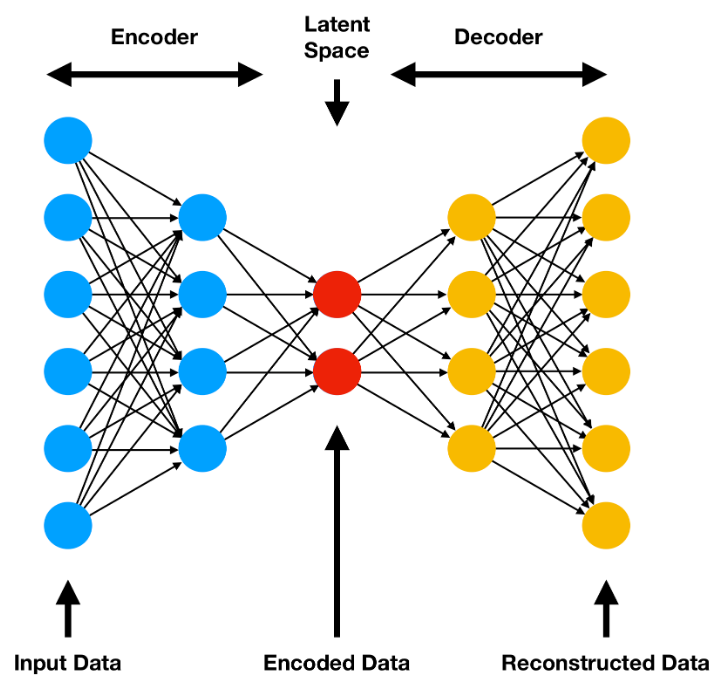

Autoencoders are a class of artificial neural networks used for unsupervised learning. There are many types of autoencoders, but the most simplest is the *undercomplete autoencoder*. Undercomplete autoencoders are designed to learn a compressed representation of the input data, remaining sensitive enough to accurately reconstruct the input data with minimal loss and drop input features which are not useful. The input data will be squeezed through the bottleneck (or latent space) and then reconstructed to original size on its way out.

As seen in the diagram above, a traditional autoencoder consists of two main components: the encoder and the decoder.

## Encoder
The encoder's job is to compress the original data into a latent space representation. Normally, the encoder is built as layers of nodes, where each layer reduces the dimensionality of the data. As the data is constricted, the encoder will learn to extract only the most useful bits of information and discard any redundant or otherwise useless parts of the dataset.

## Latent Space
The output of the encoder is the latent space, a compressed representation of the input data. In an *undercomplete autoencoder*, this space should be a lower-dimensional form of the data which captures all important characteristics of the original dataset. The latent space is also the input to the decoder.

## Decoder
After the latent space, we have the decoder. The decoder's job is to reconstruct the original data from the latent space. The architecture is similar to that of the encoder. Usually, it is simply a slightly modified encoder architecture in reverse. The decoder will attempt to learn to generate the original data from the latent space, minimizing the difference between the reconstructed data and the original input.

## Loss Function
An autoencoder uses the dissimilarity between the original and reconstructed data as its loss function. This dissimilarity is otherwise known as the *reconstruction error*. Depending on the type of data it attempts to reconstruct, this error can be defined in different ways. Mean Squared Error (MSE) and binary cross-entropy are often used here.

# What are variational autoencoders?
Variational autoencoders are similar to autoencoders. The primary difference between them is that although traditional autoencoders try and learn a distribution about how the input features of the dataset are interconnected, a variational autoencoder attempts to learn a distribution that generates the features themselves. VAEs map the input data to a gaussian probability distribution in the latent space. Then, this distribution can be sampled and the resultant vector decoded to generate releastic new data points which are statistically similar to those in the original training set.  

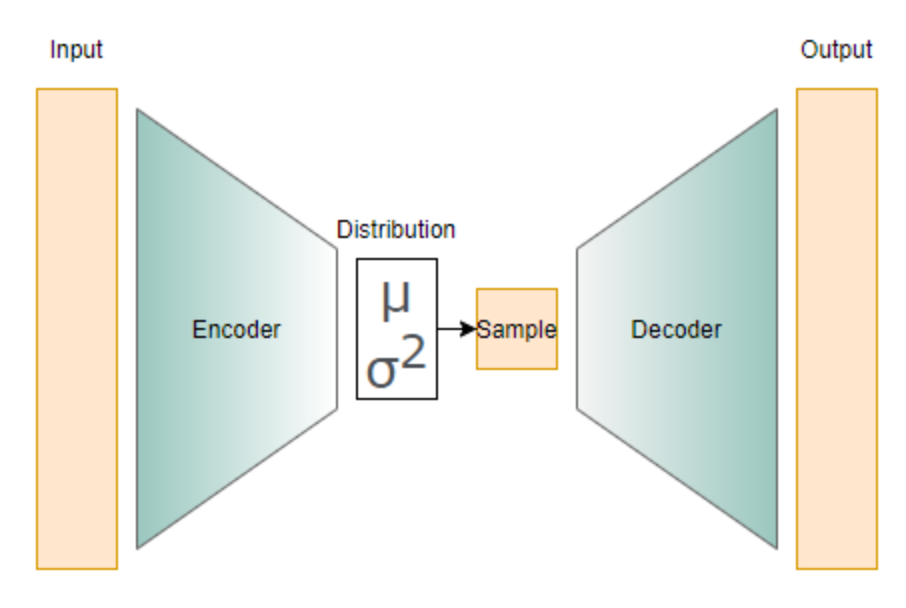

The encoder, decoder, and loss function are very similar to that of a traditional autoencoder with a few key differences.

## Encoder
The structure of the encoder is mostly similar to a traditional autoencoder. The only difference is that instead of mapping the input data points to points in the latent space, the encoder is built to map the input data points to the parameters of the latent distribution, the mean and variance ($\mu$ and $\sigma^2$). This distribution is then randomly sampled to construct the latent space. 

## Latent Space
The learned latent distribution is sampled to contruct the latent space. These samples are the input to the decoder.

## Decoder
The decoder of a variational autoencoder has no differences to the traditional. It is also neural network whose job is to reconstruct the original data from the latent space.

## Loss Function
Variational autoencoders use a loss function with two main components:
- **Reconstruction Loss**: Just like traditional autoencoders, the reconstruction loss captures the difference between the original input data and the reconstructed data from the decoder.
- **KL-Divergence Loss**: In VAEs, a Kullback-Leibler (KL) divergence loss is added to the loss function in order to enforce the latent space to follow a gaussian distribution. This is a regularizing term.


# Leveraging Generative Capabilities of VAEs

Now, with some understanding of variational autoencoders, we can start thinking about how we may apply its generative capabilites. The question that naturally arises is: how can we harness this generative power?

## A Hypothetical Problem: Class Imbalance

Consider a simply binary classification problem where the task is to predict whether any given image is of a dog or a cat. Now, suppose that you have a dataset containing 1000 images of dogs and 10000 images of cats. Therefore, you have ten-fold more instances of cats than dogs in your dataset.  

Here, we run into the issue of class imbalance. In other words, the class distribution is highly weighted in favor of one class. This is a common problem faced by machine learning engineers everyday. Machine learning models will may struggle to identify dogs in this scenario, as the dataset simply does not contain as many examples for the dog class. Additionally, some models may tend to predict the majority class more of the time, leading to biased predictions and innacurate results.  

So, how can we solve this problem. There are many approaches which you could take, the most simple of which is to reduce the total number of cat images to equal that of dog images. However, with this solution, you risk training a worse model due to the lack of data.

Enter variational autoencoders and synthetic data generation. In this case, you could utilize VAEs to synthetically generate images of cats, based on the learned latent distribution and thus solve this issue of class imbalance. By balancing the class distribution and providing the model with more examples of the minority class, you can improve its ability to correctly predict labels for the minority class (dogs).

# Worked Example

Let's try and address the problem of class imbalance using VAEs in the way described above!  

In our case, we will be generating new image samples for the MNIST Handwritten Digit Dataset. Suppose, hypothetically, that images of handwritten 0's are lacking in our dataset, and so 0 is our minority class label. To fix this, we can build and train a variational autoencoder for the purpose of generating images of handwritten 0's.

## Imports

Finally, we can get into the code. We are going to start with our imports. We will be building our VAE model with keras, so most of the inputs will be for layer types and such. Also, we will be using numpy for some matrix computations and matplotlib for some visualizations. 

In [1]:
# Imports
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

## Data Preprocessing

We are going to use the MNIST Handwritten Digist Datset for this project, so we must load this in. Thankfully, the images can be loaded with keras. Here we also want to pull only images of 0's, since it is the minority class we want to generate samples for. To make sure we have the right images in our set, we will display one of the images from the training set along with its label.

Label for Image: 0


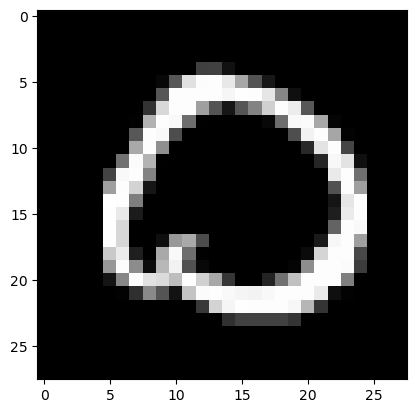

In [2]:
# Load data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Pull only images of hand-drawn zeroes
X_train_zeroes = X_train[y_train == 0]
y_train_zeroes = y_train[y_train == 0]

X_test_zeroes = X_test[y_test == 0]
y_test_zeroes = y_test[y_test == 0]

image = X_train_zeroes[100, :].reshape(28, 28)
plt.imshow(image, cmap='gray')
print(f'Label for Image: {y_train_zeroes[100]}')

In the cell below, we are simply converting the values to 32-bit precision for the model, so the model won't have to do it later. The division by 255 is for scaling the input features between 0.0 and 1.0. This scaling is recommended for neural networks, especially with default hyperparameters.

In [3]:
X_train_zeroes = X_train_zeroes.astype("float32") / 255
X_test_zeroes = X_test_zeroes.astype("float32") / 255

# Reshape dataset to shape of (28, 28, 1) expected by the model
X_train_zeroes = np.reshape(X_train_zeroes, newshape=(X_train_zeroes.shape[0], X_train_zeroes.shape[1], X_train_zeroes.shape[2], 1))
X_test_zeroes = np.reshape(X_test_zeroes, newshape=(X_test_zeroes.shape[0], X_test_zeroes.shape[1], X_test_zeroes.shape[2], 1))

X_train_zeroes.shape

(5923, 28, 28, 1)

## Sampling Layer

Before constructing anything else, we have to define a custom keras layer for the sampling layer. The sampling layer is the latent space in the VAE model. The layer will use the mean and variance inputs to trasnform them into a normal distribution. The output of this layer will be the latent space.

In [4]:
# Create sampling layer
class Sampling(layers.Layer):
    """Use (z_mean, z_log_var) to sample z (latent space)"""
    
    # Call override
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Encoder
Now, we can build the encoder. Let's define a function to make it a bit easier to build when we have to do so later. We use 2D-convolutional layers to capture some spatial patterns and learn features in our images. For a stable training, we use batch normalization layers to normalize the features. Finally, leaky rectified linear unit (LeakyReLU) is used as the activation layer to mitigate vanishing gradients by allowing negative gradients in training.

The architecture here is subject to a lot of tuning. You can change any of this to better suit the specific problem you may be working with. 

After the primary encoder layers, we will flatten the vectors from shape (7, 7, 64) into a 1D vector for the latent space. Then, since we are attempting to learn a distribution from the data, we will feed the flattened vector is fed into mean and variance layers (representing the distribution's parameters).  

Finally, the parameters are given to the sampling layer to randomly sample a normal distribution. This sample is the output of the encoder

Here, *img_size* and *img_channels* is used for setting the shape of the input layer. The *latent_dim* parameter can also be customized here. The encoder model and the *pre_flatten_shape*, used for reconstruction in the decoder, are returned.

In [5]:
# Define function for building the encoder
def build_encoder(img_size, img_channels, latent_dim):
    
    # Input layer
    input_layer = Input(shape=(img_size, img_size, img_channels), name='encoder_in')
    
    # Level 1
    x = Conv2D(filters=1, kernel_size=(3, 3), padding='same', strides=1, name='level_1_conv')(input_layer)
    x = BatchNormalization(name='level_1_batchnorm')(x)
    x = LeakyReLU(name='level_1_activation')(x)
    
    # Level 2
    x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, name='level_2_conv')(x)
    x = BatchNormalization(name='level_2_batchnorm')(x)
    x = LeakyReLU(name='level_2_activation')(x)
    
    # Level 3
    x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=2, name='level_3_conv')(x)
    x = BatchNormalization(name='level_3_batchnorm')(x)
    x = LeakyReLU(name='level_3_activation')(x)
    
    # Flatten
    pre_flatten_shape = tf.keras.backend.int_shape(x)[1:]
    x = Flatten(name='flatten')(x)
    
    # Mean and Var
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    
    # Latent Space (aka bottleneck)
    z = Sampling(name='z')([z_mean, z_log_var])
    
    # Encoder
    encoder = Model(input_layer, [z_mean, z_log_var, z], name="encoder")
    
    return encoder, pre_flatten_shape

We have completed the encoder, so let's build it and take a look at the summary to see it if everything looks good. We will build it with *img_size* of 28, 1 channel for grey, and a latent dimension of 2.

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_in (InputLayer)        [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 level_1_conv (Conv2D)          (None, 28, 28, 1)    10          ['encoder_in[0][0]']             
                                                                                                  
 level_1_batchnorm (BatchNormal  (None, 28, 28, 1)   4           ['level_1_conv[0][0]']           
 ization)                                                                                         
                                                                                                  
 level_1_activation (LeakyReLU)  (None, 28, 28, 1)   0           ['level_1_batchnorm[0][0]']

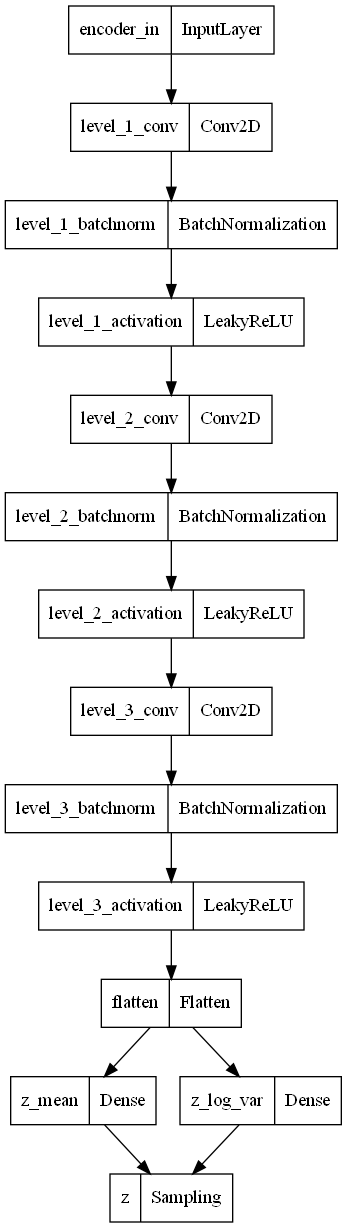

In [6]:
# build encoder
encoder, pre_flatten_shape = build_encoder(28, 1, 2)
encoder.summary()
plot_model(encoder)

Everything looks good! We can see the the input is a 28x28 image with 1 channel for grey. The final output is a vector of length 2.

## Decoder

Now, onto the decoder. Here, we are essentially reversing the architecture of the encoder, without using the sampling layer.  

The decoder is fed a latent vector of length 2 (from the encoder), and will try and reconstruct the 28x28 image from it. Here we will use the *pre_flatten_shape* from above to expand the latent vector to size (7,7,28). Also, instead of using Conv2D layers, we are using Conv2DTranspose layers. This is because the transpose is used for upsampling, while Conv2D is usually used for downsampling or feature extraction.  

Finally, there is no batch normalization done after the last level of the decoder, as it will mess up the output images that we get back. Normalization is not needed here as it is the output of the model.

In [7]:
# Define function for building the decoder
def build_decoder(pre_flatten_shape, latent_dim):
    
    # Input from decoder
    latent_input = Input(shape=(latent_dim), name='decoder_in')
    
    # Expand latent vector length to pre_flatten_shape
    x = Dense(np.prod(pre_flatten_shape), name='expand_latent_vector')(latent_input)
    
    # Reshape to (7, 7, 64) aka pre_flatten_shape
    x = Reshape(target_shape=pre_flatten_shape)(x)
    
    # Level 1
    x = Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same', strides=2, name='level_1_conv')(x)
    x = BatchNormalization(name='level_1_batchnorm')(x)
    x = LeakyReLU(name='level_1_activation')(x)

    
    # Level 2
    x = Conv2DTranspose(filters=32, kernel_size=(3, 3), padding='same', strides=2, name='level_2_conv')(x)
    x = BatchNormalization(name='level_2_batchnorm')(x)
    x = LeakyReLU(name='level_2_activation')(x)
    
    # Level 3
    x = Conv2DTranspose(filters=1, kernel_size=(3, 3), padding='same', strides=1, name='level_3_conv')(x)
    x = LeakyReLU(name='level_3_activation')(x)

    
    # Output Layer
    output_layer = x
    
    # Decoder
    decoder = Model(latent_input, output_layer, name="decoder")
    
    return decoder

Again, like we did with the encoder, let's build it to make sure we have constructed it correctly.

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_in (InputLayer)     [(None, 2)]               0         
                                                                 
 expand_latent_vector (Dense  (None, 3136)             9408      
 )                                                               
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 level_1_conv (Conv2DTranspo  (None, 14, 14, 64)       36928     
 se)                                                             
                                                                 
 level_1_batchnorm (BatchNor  (None, 14, 14, 64)       256       
 malization)                                                     
                                                           

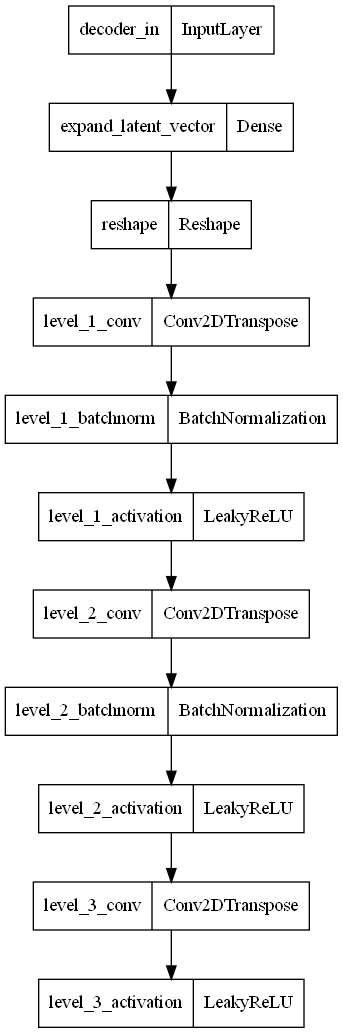

In [8]:
# build decoder
decoder = build_decoder(pre_flatten_shape, 2)
decoder.summary()
plot_model(decoder)

The input and output shapes look correct, so we can move on.

## Variational Autoencoder
Since we now have both an encoder and decoder model build, we can put the two together to build the full variational autoencoder.  

We will be subclassing a keras model and customizing some functions to make this work. The functions are detailed below.

### Initializer
This is how we will initialize our class. We are setting the encoder and decoder that we passed in to attributes for this model. Loss trackers are set too.

### Metrics
The metrics function will collect metric values and display them during fit. These metrics are also logged by the History object returned after the model fit is complete. We simply list the metrics we want returned.


### Train Step
Our custom training step will first send data into the encoder to be encoder. The mean, variance, and latent vectors are returned. The latent vector is then fed into the decoder to get the reconstructed data.  

After we have done all that, we can compute the losses. The *reconstruction_loss* will use binary crossentropy to evaluate the difference between the original data and the reconstructed data. The *kl_loss* penalizes deciations from a gaussian distribution, thus enforcing a gaussian structure in the latent space. Finally, the aforementioned two losses are added together to get the total loss.  

Then, we compute and apply the gradients according to the total loss.  

Finally, we update the state of the loss trackers and return the losses.

### Test Step
This step is exactly the same as the train step, without computing and applying gradients.

### Call
Nothing is important here. We will just override the call method to let us save the model later.

In [9]:
# Subclass Model to build custom VAE model
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        
        super().__init__(**kwargs)
        
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean( name="reconstruction_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Get Mean, Var, and Latent Space from encoder
            z_mean, z_log_var, z = self.encoder(data)

            # Reconstruct data from encoder with decoder
            reconstructed_data = self.decoder(z)

            # Compute losses
                # BCE as reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                        tf.keras.losses.binary_crossentropy(data, reconstructed_data), axis=(1,2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        # Compute and Apply Gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update and Return Losses
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss" : self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }    
    
    def test_step(self, data):        
        if isinstance(data, tuple): data=data[0]
        
        # Get Mean, Var, and Latent Space from encoder
        z_mean, z_log_var, z = self.encoder(data)

        # Reconstruct data from encoder with decoder
        reconstructed_data = self.decoder(z)
        
        # Compute losses
            # BCE as reconstruction loss
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstructed_data), axis=(1,2)
            )
        )
        
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss" : total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    
    # Override call
    def call(self, inputs):
        # Encode
        _,_, encoded = self.encoder(inputs)
        
        # Decode
        decoded = self.decoder(encoded)
        
        # Return
        return decoded

Now, we are finally done building all the models necessary. Just to make sure everything is good for a final time, we can build the variational autoencoder and check the summary. Because we have subclassed a keras Model(), we must build it and supply an input shape before we call summary().

In [10]:
vae = VAE(encoder, decoder, name="VAE")
vae.build(input_shape=(None, 28, 28, 1))
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 2),               31762     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65473     
                                                                 
Total params: 97,241
Trainable params: 96,849
Non-trainable params: 392
_________________________________________________________________


## VAE Training

Our model is built and looks good. We can finally move on to training it. Before training, we must compile the model. We will be using Adam as the optimizer and implementing early stopping for our training run. We will stop the model and restore weights if we see that the validation loss is not improving over the course of 5 epochs. We do this so that we don't overfit the training set and lose diversity in our generated samples.  

Next, we can fit the model. Please note that the hyperparameters here should be tuned for your own specific application.

In [11]:
# Compile VAE
vae.compile(optimizer = 'Adam')

# Implement Early Stopping
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Fit model
history = vae.fit(X_train_zeroes, epochs=30, batch_size=32, verbose=1, validation_data=(X_test_zeroes, X_test_zeroes), callbacks=[early_stopping_monitor])

Epoch 1/30
186/186 [==============================] - 12s 40ms/step - loss: 345.8434 - reconstruction_loss: 247.5872 - kl_loss: 4.2870 - val_loss: 213.5212 - val_reconstruction_loss: 209.8647 - val_kl_loss: 3.6564
Epoch 2/30
186/186 [==============================] - 9s 51ms/step - loss: 186.8021 - reconstruction_loss: 177.8391 - kl_loss: 4.6771 - val_loss: 190.5041 - val_reconstruction_loss: 186.1507 - val_kl_loss: 4.3534
Epoch 3/30
186/186 [==============================] - 9s 49ms/step - loss: 176.8980 - reconstruction_loss: 171.3472 - kl_loss: 4.4693 - val_loss: 184.7307 - val_reconstruction_loss: 180.6282 - val_kl_loss: 4.1025
Epoch 4/30
186/186 [==============================] - 8s 43ms/step - loss: 202.7932 - reconstruction_loss: 209.7681 - kl_loss: 3.4402 - val_loss: 209.2005 - val_reconstruction_loss: 204.4895 - val_kl_loss: 4.7111
Epoch 5/30
186/186 [==============================] - 8s 42ms/step - loss: 186.5974 - reconstruction_loss: 177.4946 - kl_loss: 4.1463 - val_loss: 1

## VAE Visualizations

Once the model is done training, we can visualize the learning curves by plotting the losses.

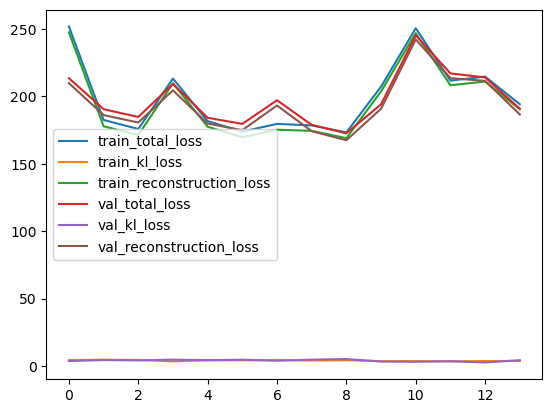

In [12]:
# Visualize Learning Curves
plt.plot(history.history['loss'], label='train_total_loss')
plt.plot(history.history['kl_loss'], label='train_kl_loss')
plt.plot(history.history['reconstruction_loss'], label='train_reconstruction_loss')
plt.plot(history.history['val_loss'], label='val_total_loss')
plt.plot(history.history['val_kl_loss'], label='val_kl_loss')
plt.plot(history.history['val_reconstruction_loss'], label='val_reconstruction_loss')
plt.legend()
plt.show()

Here, we can see that our training and validation losses do not differ much. This is a good sign that we haven't overtrained our model. The losses are a bit jumpy, but that is okay since we do not neccesarily want a perfect reconstruction of the data. Remember, we want to generate plausible new sample images for the dataset. They should not be perfect reconstructions of our training set, but should retain the same general structure (aka look like handwritten zeroes).  

Great! We now have a trained variable autoencoder. Now what?  

This is the exciting part. We can now sample from the learned latent space to generate new samples.  

With *np.random.normal*, we can draw random samples from a normal distribution with mean 0 and standard deviation of 1. Then, we specify an output shape for the samples. Next, we feed the random sample into the decoder to decode the sampled latent vector back into the original data space. After all this, we will have a synthetically generated sample image.  

Below we generate 10 new sample images and display them.

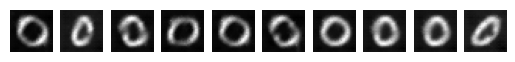

In [13]:
num_samples = 10

fig, axes = plt.subplots(1, num_samples)
for i, ax in zip(axes, range(num_samples)):
    latent_sample = np.random.normal(0, 1, (1, 2))
    decoded_sample = vae.decoder.predict(latent_sample, verbose=0)
    sample_image = decoded_sample.reshape(28, 28)
    
    axes[ax].imshow(sample_image, cmap='gray')
    axes[ax].axis('off')


We can see that all the images generated are realistic representations of handwritten zeroes. They all are slightly imperfect, confirming that we have not lost all diversity in our generated samples. This is a good thing as we want diverse samples in order to train a robust classification model later on.  
For a better understanding of the latent space, we can visualize the space with the images we generate from our latent vector of length 2. I chose a latent dimension of 2 mostly for this purpose.  

Below, we define a function to generate samples throughout the latent space.

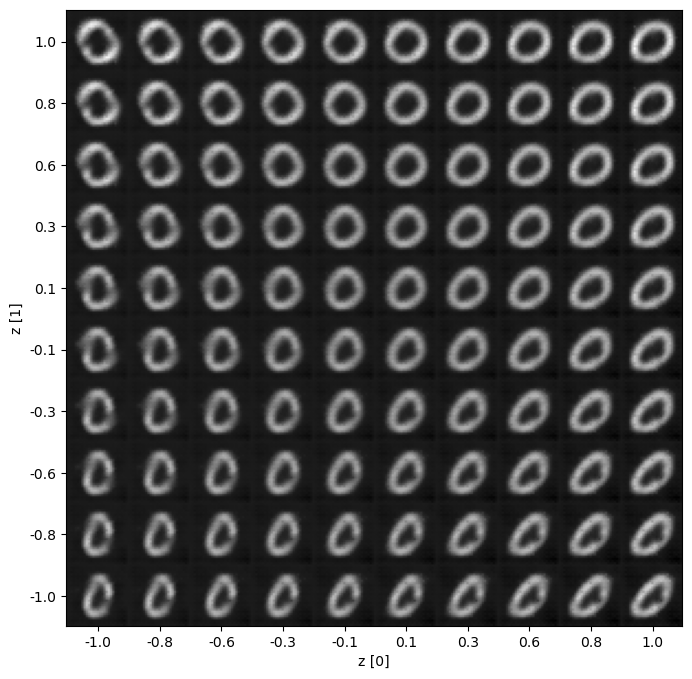

In [15]:
def latent_space_viz():
    # Initialize figure as zeroed array
    figure = np.zeros((28 * 10, 28 * 10))
    
    # Evenly spaced vector for x and y values in latent distribution
    grid_x = np.linspace(-1, 1, 10)
    grid_y = np.linspace(-1, 1, 10)[::-1]
    
    for idx_0, y in enumerate(grid_y):
        for idx_1, x in enumerate(grid_x):
            # Generate sample
            latent_sample = np.array([[x, y]])
            decoded_sample = vae.decoder.predict(latent_sample, verbose=0)
            img = decoded_sample[0].reshape(28, 28)
            
            # Set image in figure grid
            figure[idx_0*28 : (idx_0+1)*28, idx_1*28 : (idx_1+1)*28] = img
            
    # Setting figsize, ticks, and labels
    plt.figure(figsize=(8, 8))
    pixels = np.arange(28//2, 10*28+(28//2), 28)
    plt.xticks(pixels, np.round(grid_x, 1))
    plt.yticks(pixels, np.round(grid_y, 1))
    plt.xlabel('z [0]')
    plt.ylabel('z [1]')
    plt.imshow(figure, cmap='gray')
    plt.show()
    
latent_space_viz()            

From this visualization, it is easy to see how the model has mapped variations of handwritten 0's to the latent space. Some are a bit skewed and others a bit more "perfect". And since the distribution is continuous, we can draw an infinite number of samples. Between each of the displayed images, there are infinitely many more which are slightly different than the ones we see. This is simply a 10x10 grid of 100 generated samples.  

Similar to other common forms of data augmentation, we seem to have covered some rotation and some scaling in our generated set. This diversity is great for training robust models with our new data. 

# Conclusion
In the current day and age, where data has such an importance to daily life, variational autoencoders and generative AI stand to change the face of data aggregation forever. We have seen how VAEs can learn latent distributions for generating features. More specifically, how VAEs can learn distributions for generating images based on some training data. VAEs have not simply learned to copy images, but instead have learned what makes the image what it is, and give us new examples. It has grasped the concept of what a "handwritten 0" is.  

Throughout this blog, I have covered foundational concepts regarding autoencoders and the variational variant of such. We have explored their architecture and how the encoders and decoders work in tandem for construction of the latent space. We dove into the loss functions, and how VAEs can be used to generate through latent space sampling. And we even worked through an example of one of the many applications for VAEs.  

Generative AI is new and cutting-edge, and it has only just begun. Who knows what generative models could have for us in years to come.